# Data Science 2 Math 4366
# Spring 2021 Tarleton State University
# Masters in Mathematics
# Dr. Scott Cook
# Homework 1

update 2/16 - Thanks to our snow days, I've had more time to explore this HIV model and PyMC3's handling of it.  Good news - this model behaves better and converges in fewer MCMC steps than the English Boarding School one.  However, each MCMC step takes longer.  Consequently, I'm altering a few details to save you some time and frustration.

- Different cutoffs for questions #3&4 - It turns out the answers to the original versions were 0 because this HIV model is much more effective.  So, I changed the cutoffs so to make the questions more worthwhile.
- Use fewer steps
    - terminology:
        - "posterior_predictive plots" show $S$ or $I$ or $I_j$ vs time
        - "posterior plots" show distributions of parameters $\alpha$, $\beta$, $\gamma$
        - I'm running on GCP AI notebook instance c2-standard-4 (Compute Optimized: 4 vCPUs, 16 GB RAM) with "cores=4" and "draws=4*tune"
    - tune=10 → 160 draws_total, ~1 minute - posterior_predictive plots look OK, but the posterior plots are terrible and there are many divergences.  Use this while writing/debugging code so you're not waiting for long runs.  Once your posterior_predictive plots look good (red ODE solution passes through centers of boxplots), increase tune to...
    - tune=50 → 800 draws_total, ~1 hr - both the posterior_predictive and posterior plots look great and few divergences.  Use this once your code is working to get the "real data" to use for the questions.
    - We really should do more tune & draws than this, but I don't want to make you wait that long.
    - I edited lines 13, 14, 153, 154, and 170 so the filename includes "draws_total" to avoid overwriting the same file.
    - Divergences indicate the MCMC sampler had some problems.  Curiously, the number of divergences goes down as tune goes up, even though there are MORE steps where divergences could occur.  Why?  Divergences happen early.  If tune is large enough, they get thrown out with tuning set.  We're not going to dedicate time to really dig into divergences nor techniques to speed things up.  But, if you are curious, you can read more at https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/Diagnosing_biased_Inference_with_Divergences.html.

Start of original version of hwk

Below is the final* version of my code for the English Boarding School SIR model in $\S 6.2.1$ p.126-130 of An Introduction to Mathematical Epidemiology.

Recall, the goal is to convert the single point estimate approach to a Bayesian framework using PyMC3.  In this way, we estimate our model parameters and prediction in a way that reflects our level (or lack) of confidence based on our limited data.

This took me a long time because I explored many options for how much noise to inject, whether to normalize to proportions,  where to set eps, how to handle missing day 2 data, etc.  To spare you that time, we'll declare:
- noise - Too much noise → predictions are noisy; too little → long run times and vulnerable to divergences.  In the end, 0.02 gave me the best balance of model accuracy and run time.  So, use noise=0.02.
- eps = 0.2 - I don't have a good justification, but let's stick with it unless you find a good reason to change.
- for this hwk, there is no equivalent of missing day 2 data
- for pm.sample
    - draws = 4*tune   
    - (ignore this and see edit above) tune = 500 (unless this takes a really long time - let me know if so)
    - other settings as above unless you find a good reason to chagne something.  In that case, *please* let me know because I'm still learning about PyMC too.
    - I think you should convert a Kaggle kernel to a Google AI notebook.  When writing & debugging code, use a small cheap instance like E2 1vCPU. But, when you're ready for a big run, I've had good luck with the "compute optimized 4vCPU".  Yes, its more expense at \$0.20/hr, but the free 300 does go a long way at that rate.

Your assignment: give the same treatment to the example in $\S 6.2.2$ p.130-133 of HIV/AIDS prevalence.
- Due to the way HIV progresses, the infected $I$ class is modeled with 4 subclasses where $I = I_1 + I_2 + I_3 + I_4$.
    - ODE model recognizes all 4 subclasses
    - Observed data combines them as a single $I$ class.
    - This is an example of a hierarchial model with interal variables that influence the system, but are not directly observed.
    - I found it helpful to maintain separate variables for the top-level with one $S$ & one $I$ and the lower-level with one $S$ & four $I_j$.
        - More specifically, the English Boarding School code has variables called y, obs, and z.
        - My code to solve this hwk has y_SIR, y_HIV, obs_SIR, obs_HIV, z_SIR, and z_HIV.  Each _SIR has 2 classes (one $S$ & one $I$) and each _HIV has 5 classes (one $S$ & four $I_j$).
        - I have 2 functions to convert between these variables.
            - HIV_to_SIR sums the four $I_j$ subclasses into one $I$ class
            - SIR_to_HIV decomposes a one $I$ into four $I_j$ subclasses.  This is trickier
                - Q: How much of the one $I$ should be apportioned to each $I_j$?
                - A: Let y_HIV be the (normalized) solution to the ODE and let sir be the top-level variable you wish to decompose.  Complete the following function:
```
def SIR_to_HIV(sir):
    """ Expand total I to subclasses proportional to ODE solution """
    # I[j,t] = y_HIV[j+1,t] = infections in each subclass at time t in ODE solution
    I = y_HIV[1:]
    # T[t] = total infections at time t in ODE solution
    T = __________
    # K[j,t] = I[j,t] / T[t] = proportion of total infections in each subclass at time t in ODE solution (uses Numpy broadcasting)
    K = __________
    # assign total infections at time t in sir[1,t] to subclasses proportional to K[j,t] (uses Numpy broadcasting)
    return np.vstack([sir[0], sir[1]*K])
```
- Recall that PyMC3 tends to do better on "normalized" proportional data than on "raw" counts. However, the textbook presents the model and its point estimates as raw counts.  Thus, we define new variables $\bar{S} = \frac{S}{N}$, $\bar{I} = \frac{I}{N}$, $\bar{I_1} = \frac{I_1}{N}$, ..., $\bar{I_4} = \frac{I_4}{N}$.
    - In class, we showed how to convert the ODE into barred variables, which in some cases changed the parameter (ex: for SIR, $\bar{\beta} = \beta N$.  I *think* that the only parameter changes here is $\bar{\Lambda} = \frac{\Lambda}{N}$; otherwise all barred parameters equal their unbarred counterparts.  However, I would appreciate someone checking my work.
    - In the English Boarding school, we could safely assume total population is constant b/c it took place over 14 days and flu isn't very deadly.  However, this problem spans 20 years, so total population fluxuates.  Nonethless, I believe we will still get reasonable results if we assume contant population for the sake of simplicity.
        - Caution: the N in $\lambda(t) = \beta e^{-\alpha I(t)/N(t)} I(t)/N(t)$ on p.131 is NOT this constant total population.  You need to compute $N(t) = S(t) + I_1(t) + I_2(t) + I_3(t) + I_4(t)$ INSIDE the ODE function.
- Being experts in this domain, the authors made choices to fix $\Lambda$ and $\mu$.  Follow their lead.
- To generate random numbers, use np.random.default_rng(seed) so that we all get results that are as similar as possible.
1. Your job - fit $\alpha$, $\beta$, and $\gamma$ using a Bayesian approach.  Generate and plot posterior distributions that are compatible with the book's point estimates.
    - As with the code above, you may "cheat" by using the book's point estimates for $\alpha$, $\beta$, and $\gamma$ in Table 6.3 to generate $y$ from the ODE.  You may also use them to set loc for your priors with some random error via "val * np.random.default_rng(seed).uniform(1-eps, 1+eps)".  After all, if we start Bayes at the correct answer, it's not very impressive if he finds the correct answer.
2. Using sample_posterior_predictive, create plots like those above.
3. In what proportion of posterior predictive samples does the $I$ class go above the observed 2011 total infection prevalance at any point between 1991 & 2011?
3. In what proportion of posterior predictive samples does the $I$ class go below the observed 1991 total infection prevalance at any point between 1991 & 2011?
4. Is there a way to extrapolate out to later years?  As I write this, I am not sure.  But if there is, I'd like to know if/when the $I$ class starts decreasing.



For noise=0.02 ... 

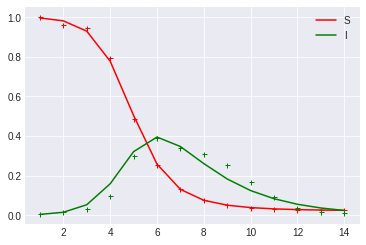

running MCMC
Sampling posterior


Sampling posterior_predictive


,draws,min,25%,50%,TRUE,mean,75%,max,prior_loc
sigma,8000,0.010355,0.018664,0.158465,1.00000,0.249442,0.464134,1.056191,1.109582
beta,8000,1.778915,1.810643,1.814841,1.80831,1.814888,1.819148,1.849720,2.006469
alpha,8000,0.457634,0.469790,0.471672,0.46500,0.471679,0.473564,0.485418,0.515956


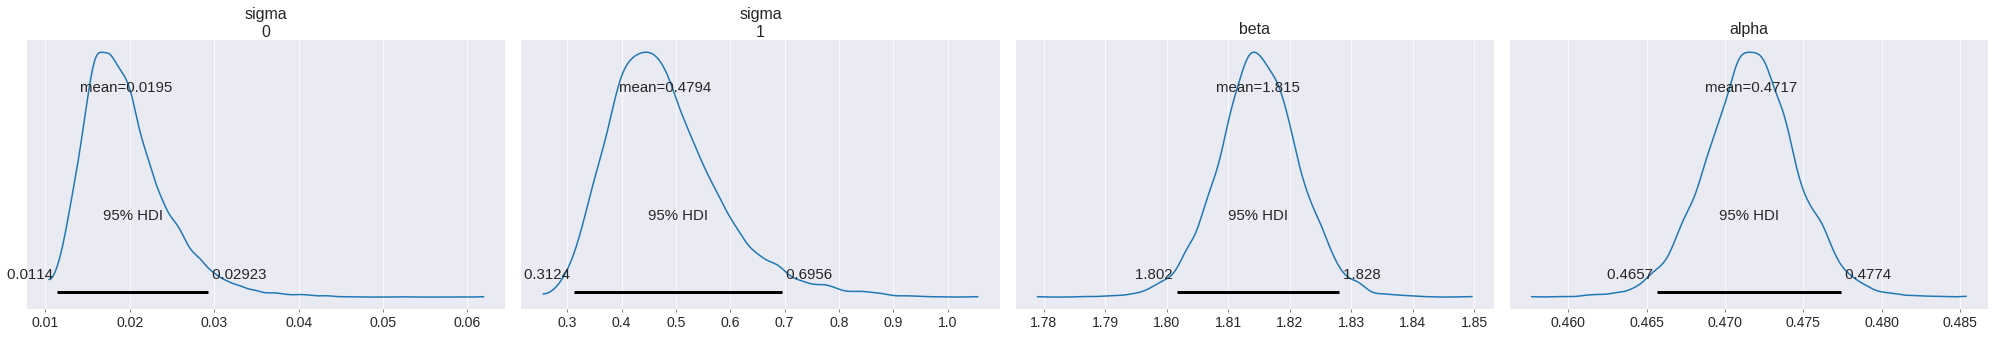

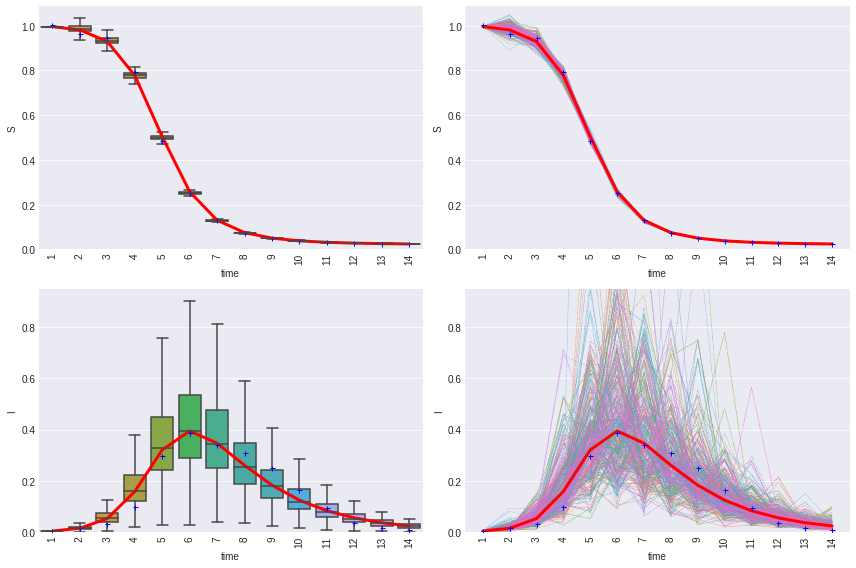

In [1]:
# Code for the English Boarding School SIR model

import os, numpy as np, scipy as sp, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, pymc3 as pm, arviz as az
plt.style.use("seaborn-darkgrid")
np.seterr(divide='ignore')

tune  = 500   # number of tuning steps before we start keeping good data
cores = 4     # kaggle kernels have 4 cores, so we can use each one to run chains in parallel
eps   = 0.2   # we want prior distributions centered near, but not right at, the true value.  eps pushes the prior away from true
seed  = 42
refresh = False  
# refresh = True  # Delete & recreate any existing data
draws = 4 * tune
draws_total = draws * cores

# initial conditions - p.126
times = np.arange(1, 15)
classes = ['S','I']
y0 = [760, 3]
N = np.sum(y0)

# published parameter point estimates - p.129
theta = {'beta' : 0.00237, 'alpha': 0.465}
n_theta = len(theta)

# ODE model - p.126
def ODE(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di =  p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

def inject_noise(noise, seed):
    """Add noise to S class predictions from odeint"""
    z = obs.copy()
    z[0] = np.random.default_rng(seed).lognormal(mean=np.log(z[0]), sigma=noise)
    return z

def plot_data(z):
    colors = ['red', 'green', 'orange', 'blue', 'yellow', 'violet']
    d = {'marker':'+', 'markersize':5, 'linestyle':''}
    for i in range(0, 2):
        clr = colors.pop(0)
        plt.plot(times, y[i], c=clr, label=classes[i])
        plt.plot(times, z[i], c=clr, label=None, **d)
    plt.legend()
    plt.show()
    
# ODE model in book works on raw counts, but PyMC3 does better with proportions
# So, we will run initially create and run the raw version to get ODE solutions,
# but then "normalize" to proportions to run Bayes.
# This may require adjustement to both the variables and parameters, as discussed in lecture.

# Run ODE on counts, then normalize to propotions
y = sp.integrate.odeint(ODE, y0, times, (list(theta.values()),), rtol=1e-8)  # get ODE predictions
y = y.T / N  # normalize & transpose
# incorporate observations in Table 6.1 p.126
obs = y.copy()
obs[1, 2:] = np.array([25,75,227,296,258,236,192,126,71,28,11,7]) / N

# normalize parameters - beta must be multiplied by N, all others unchanged
theta_n = theta.copy()
theta_n['beta'] *= N
theta_n['sigma'] = 1.0

# guess loc for priors, but inject some error so Bayes doesn't get to start at the correct answer
theta_loc = {key: val * np.random.default_rng(seed).uniform(1-eps, 1+eps) for key,val in theta_n.items()}

# create pymc3 ODE object
ODE_pymc3 = pm.ode.DifferentialEquation(
    func=ODE,
    times=times[1:],
    t0=times[0],
    n_states=len(classes),
    n_theta=n_theta)

def make_model(z=obs):
    """Creates the pymc3 model object, but does not run it"""
    with pm.Model() as model:
        # Choose priors on alpha, beta, and sigma
        sigma_prior = pm.HalfCauchy("sigma", theta_loc['sigma'], shape=len(classes))
        params = theta_loc.copy()
        params.pop('sigma')
        theta_prior = [pm.Lognormal(key, mu=pm.math.log(loc), sigma=1.0) for key,loc in params.items()]
        curves = ODE_pymc3(y0=z.T[0], theta=theta_prior)
        Z = pm.Lognormal("Z", mu=pm.math.log(curves), sigma=sigma_prior, observed=z.T[1:])
    return model

def analyze(idata):
    """Analyzes results of pymc3 run"""
    # Compute stats on parameters posterior distributions
    theta_stats = idata.posterior.to_dataframe().describe().T  # 7-number summaries
    theta_stats['draws'] = idata.posterior.beta.size  # count
    theta_stats['TRUE'] = pd.Series(theta_n)          # true value from p.126
    theta_stats['prior_loc'] = pd.Series(theta_loc)   # start value for bayes
    theta_stats = theta_stats[['draws', 'min', '25%', '50%', 'TRUE', 'mean', '75%', 'max', 'prior_loc']]  # rearrange columns
    display(theta_stats)
    az.plot_posterior(idata, round_to=4, hdi_prob=0.95)  # plot posteriors
    plt.show()
    
    # plot posterior predictive data (aka - draw parameters from their posterior and run ODE with them)
    pred = idata.posterior_predictive.to_dataframe().reset_index().rename(columns={'Z_dim_0':'time', 'Z_dim_1':'class'})
    pred['time'] += times[1]  # replace time=0 with time=first observations
    pred = pred.pivot(['chain','draw','class'], 'time', 'Z')  # convert from "long form" to "wide form" with column for each time
    t0 = times[0]
    pred[t0] = 0.0  # create placeholder column for initial condition, to be filled in later
    pred = pred[sorted(pred.columns)]  # sort columns in order
    r = len(classes)
    fig, axes = plt.subplots(r, 2, figsize=(12, 4*r))  # create grid of plots
    i = -1  # current row of plot grid
    for c, df in pred.groupby('class'):  # make plot for each class
        i += 1
        data = df.reset_index(drop=True)
        data[t0] = y[c,0]  # fill initial condition columns created above
        for j in range(2):  # create boxplot and lineplot side-by-side
            ax = axes[i,j]
            if j == 0:
                # dt is a silly hack to make boxplot overlay correctly with ODE solution & observed data
                dt = t0
                sns.boxplot(data=data, showfliers=False, ax=ax)  # posterior predictive as boxplots
                # find good lower and upper ylim
                l = max(ax.get_ylim()[0], 0.0)
                u = min(ax.get_ylim()[1], 1.1)
            elif j == 1:
                # lineplot does not need the same silly hack
                dt = 0
                # lineplot takes a long time, so we limit the number of posterior predictions to show
                num_plots = 300
                sns.lineplot(data=data.sample(num_plots).T, linewidth=0.5, alpha=0.9, legend=False, ax=ax)  # posterior predictive data as lines
            ax.plot(times-dt, y[c], color='red' , linewidth=3)  # plot ODE solution
            ax.plot(times-dt, z[c], color='blue', marker='+', markersize=5, linestyle='')  # plot observed data
            ax.set_xticks(times-dt)
            ax.tick_params('x', labelrotation=90)
            ax.set_xlabel('time')
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)
            ax.set_ylabel(classes[c])
            ax.set_ylim(l, u)  # use l, u range from boxplot
    plt.tight_layout()
    plt.show()
    return theta_stats

def del_file(file):
    """ delete file if it exists"""
    try:
        os.remove(file)
    except OSError:
        pass

# noises = [0.01, 0.02, 0.05, 0.1]
noises = [0.02]
for noise in sorted(noises): # amount of noise to inject into ode-solved values & day to start observed data    
    print(f'\n\nFor noise={noise} draws_total={draws_total}', end=' ... ')
    file = f'/home/jupyter/idata/bayes_noise={int(noise*100)%100}_draws={draws_total}.netcdf'  # file to read & write data
    z = inject_noise(noise, seed)
    plot_data(z)
    model = make_model(z)
    with model:
        try:
            assert not refresh  # if refresh true, go to except block and re-create
            idata = az.from_netcdf(file)  # try to read existing data, if fail, go to except block and re-create
            print(f'using idata from {file}')
        except:
            # The big, intense line is below.  It runs MCMC and can take a long time
            # tune = # steps to throw away at the beginning (bad data)
            # draws = # steps to keep
            # cores = # cores in machine - use them all
            # chains = cores to use all available power
            print('Sampling posterior')
            idata = pm.sample(tune=tune, draws=draws, cores=cores, chains=cores, target_accept=0.9, return_inferencedata=True)
            # save to file for reuse
            del_file(file)
            idata.to_netcdf(file)
        # Now we have the distribution for parameters.  We'd like to see what that means for S & I evolutions
        # pymc3 calls this "sample posterior predictive"
        # If we're using existing data, it may have posterior_predictive already.  Else, generate
        if not hasattr(idata, 'posterior_predictive'):
            # Draw samples
            print('Sampling posterior_predictive')
            ppc = pm.sample_posterior_predictive(idata, keep_size=True)
            # put into idata
            az.concat(idata, az.from_dict(posterior_predictive=ppc), inplace=True)
            # delete old file and save new one
            del_file(file)
            idata.to_netcdf(file)
        analyze(idata)